## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Use fixed parameters, but input datasets with very short syllable removed. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
bd = 'pair2RigBCU25'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,8.5]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
rn = 'spec_goffinet_cutoff_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [6]:
fd_save = os.path.join(fd_data, bd, 'UMAPonVAE6', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)

print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
## load spectrograms and meta info
fn_spec = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.h5')
fn_info = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair2RigBCU25 spec_goffinet_cutoff_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/UMAPonVAE6/v/spec_goffinet_cutoff_256_176
(16410, 128, 128) (16410, 7)


In [7]:
## train VAE network
# create dataloader from h5 file
train_data = vae_goffinet.SpecDataset(fn_spec)
# set a random seed
g = torch.Generator()
g.manual_seed(42)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
loaders = {'train':train_dataloader, 'test':train_dataloader}

# init VAE model then train
model = vae_goffinet.VAE(save_dir=fd_save)
model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# save model
fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
model.save_state(fn_model)

Training: epochs 0 to 50
Training set: 16410
Test set: 16410


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 9969.8385
Epoch: 1 Average loss: 1229.6249
Epoch: 2 Average loss: 945.1487
Epoch: 3 Average loss: 805.9532
Epoch: 4 Average loss: 729.8072
Epoch: 5 Average loss: 681.0285
Epoch: 6 Average loss: 635.7114
Epoch: 7 Average loss: 600.9821
Epoch: 8 Average loss: 567.0622
Epoch: 9 Average loss: 537.2750
Epoch: 10 Average loss: 520.3071
Epoch: 11 Average loss: 497.9662
Epoch: 12 Average loss: 490.7789
Epoch: 13 Average loss: 474.3812
Epoch: 14 Average loss: 462.5525
Epoch: 15 Average loss: 450.8862
Epoch: 16 Average loss: 441.5608
Epoch: 17 Average loss: 435.6639
Epoch: 18 Average loss: 425.7015
Epoch: 19 Average loss: 431.7454
Epoch: 20 Average loss: 413.6119
Epoch: 21 Average loss: 409.4694
Epoch: 22 Average loss: 405.0014
Epoch: 23 Average loss: 397.0654
Epoch: 24 Average loss: 392.9158
Epoch: 25 Average loss: 386.7884
Epoch: 26 Average loss: 382.5320
Epoch: 27 Average loss: 378.1444
Epoch: 28 Average loss: 373.1420
Epoch: 29 Average loss: 368.6582
Epoch: 30 Average 

In [8]:
## Obtain latent representation
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

257it [00:18, 13.53it/s]


(16410, 32)


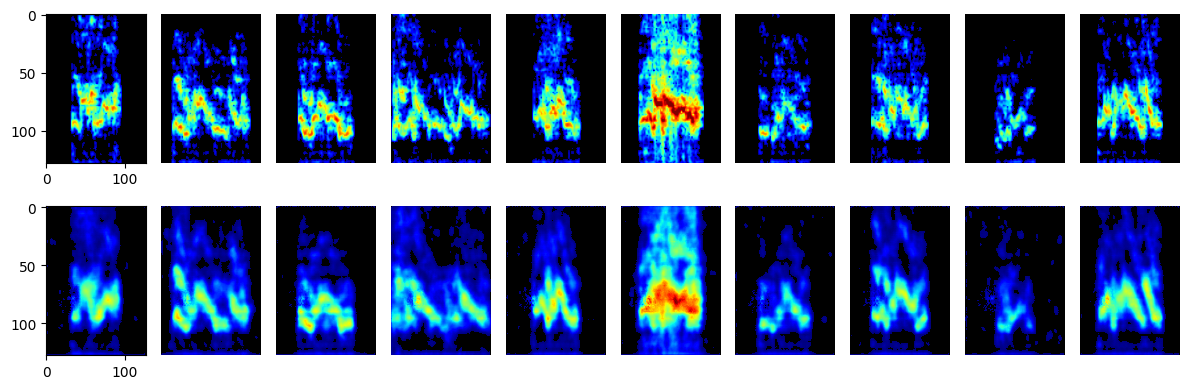

In [9]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [10]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16410, 32)

In [11]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [12]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:22 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:22 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:22 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Jun 15 22:19:25 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:34 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:43 2025 Finished embedding


In [13]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Sun Jun 15 22:20:38 2025 Worst tree score: 0.81499086
Sun Jun 15 22:20:38 2025 Mean tree score: 0.81849759
Sun Jun 15 22:20:38 2025 Best tree score: 0.82638635
Sun Jun 15 22:20:39 2025 Forward diversification reduced edges from 410250 to 146359
Sun Jun 15 22:20:41 2025 Reverse diversification reduced edges from 146359 to 146359
Sun Jun 15 22:20:43 2025 Degree pruning reduced edges from 161718 to 161718
Sun Jun 15 22:20:43 2025 Resorting data and graph based on tree order
Sun Jun 15 22:20:43 2025 Building and compiling search function


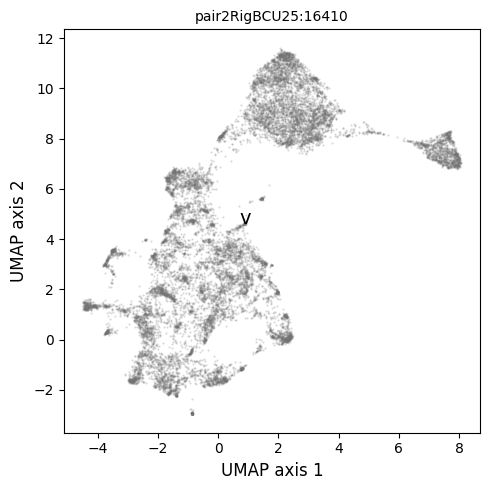

In [14]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [15]:
int(res.shape[0]* param_hdbscan['min_cluster_size_frac'])

820

In [21]:
## HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
#                             cluster_selection_method=param_hdbscan['select_method'])
clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=param_hdbscan['min_samples'],  
                            cluster_selection_method='leaf')
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.2041
Total number of clusters: 6


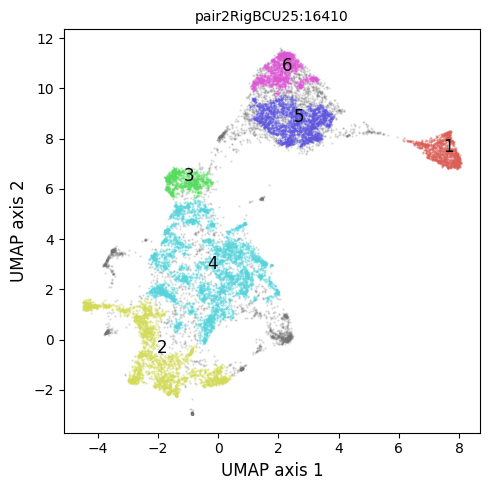

In [22]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [23]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [24]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [25]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9848
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: 0.2587
HDBSCAN Silhouette score in VAE: 0.0115
Calinski–Harabasz index in UMAP: 7705.8228
Calinski–Harabasz index in VAE: 726.6703


In [26]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair2RigBCU25,spec_goffinet_cutoff_256_176,6,0.204144,"[0.7223032772867988, 0.13138303518729075, 0.18...",0.984838,0.83313,0.258665,0.011545,7705.822796,726.670339,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [27]:
# number of trials to simulate
n = 200

In [28]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16410, 32)

In [29]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [ ]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(2288)
for i in tqdm.tqdm(range(n)):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
    #                             cluster_selection_method=param_hdbscan['select_method'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
                                cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')
    
    if num_c==0:
        continue

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:49 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:49 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:49 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:49 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:22:50 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:22:57 2025 Finished embedding
The fraction that are not clustered: 0.5856
Total number of clusters: 4
Hopkins metric in UMAP: 0.8604
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: -0.0857


  0%|          | 1/200 [00:15<51:58, 15.67s/it]

HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1909.0370
Calinski–Harabasz index in VAE: 1.0699
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:05 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:05 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:05 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:05 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:23:06 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:13 2025 Finished embedding
The fraction that are not clustered: 0.4734
Total number of clusters: 3
Hopkins metric in UMAP: 0.8466
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: -0.0282


  1%|          | 2/200 [00:30<49:21, 14.95s/it]

HDBSCAN Silhouette score in VAE: -0.0088
Calinski–Harabasz index in UMAP: 2036.6533
Calinski–Harabasz index in VAE: 1.1801
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:19 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:19 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:19 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:19 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:23:20 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:27 2025 Finished embedding
The fraction that are not clustered: 0.5764
Total number of clusters: 4
Hopkins metric in UMAP: 0.8509
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: -0.1627


  2%|▏         | 3/200 [00:44<47:42, 14.53s/it]

HDBSCAN Silhouette score in VAE: -0.0079
Calinski–Harabasz index in UMAP: 1075.5938
Calinski–Harabasz index in VAE: 1.1283
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:33 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:33 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:33 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:33 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:23:34 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:41 2025 Finished embedding
The fraction that are not clustered: 0.7981
Total number of clusters: 3
Hopkins metric in UMAP: 0.8368
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: -0.2000


  2%|▏         | 4/200 [00:58<47:32, 14.56s/it]

HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 628.8470
Calinski–Harabasz index in VAE: 1.0926
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:48 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:48 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:48 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:48 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:23:49 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:55 2025 Finished embedding
The fraction that are not clustered: 0.5416
Total number of clusters: 5
Hopkins metric in UMAP: 0.8280
Hopkins metric in VAE: 0.8331
HDBSCAN Silhouette score in UMAP: -0.1082


  2%|▎         | 5/200 [01:13<47:08, 14.51s/it]

HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1999.9615
Calinski–Harabasz index in VAE: 0.9420
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:24:02 2025 Construct fuzzy simplicial set
Sun Jun 15 22:24:02 2025 Finding Nearest Neighbors
Sun Jun 15 22:24:02 2025 Building RP forest with 11 trees
Sun Jun 15 22:24:02 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Jun 15 22:24:03 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:24:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs


In [33]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
print(metrics.shape)
metrics.head()

(200, 13)


,birdID,run_id,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair2RigBCU25,0,4,0.585558,"[0.04712656221250353, 0.04628476446453327, 0.0...",0.860359,0.83313,-0.085738,-0.003824,1909.037034,1.069911,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair2RigBCU25,1,3,0.473431,"[0.05727993429322819, 0.026331171528707526, 0....",0.846575,0.83313,-0.028162,-0.008790,2036.653325,1.180056,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair2RigBCU25,2,4,0.576356,"[0.01523300497428068, 0.004689318430120115, 0....",0.850904,0.83313,-0.162695,-0.007871,1075.593775,1.128286,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair2RigBCU25,3,3,0.798111,"[0.006581975018290378, 0.024114439238771608, 0...",0.836824,0.83313,-0.200020,-0.004150,628.847037,1.092635,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair2RigBCU25,4,5,0.541621,"[0.00729676675901721, 0.05422924023528837, 0.0...",0.828049,0.83313,-0.108163,-0.006321,1999.961475,0.942026,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


### Plot the random distribution of clustering metrics

In [34]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair2RigBCU25,spec_goffinet_cutoff_256_176,6,0.204144,[0.72230328 0.13138304 0.18340286 0.13920512 0...,0.984838,0.83313,0.258665,0.011545,7705.822796,726.670339,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


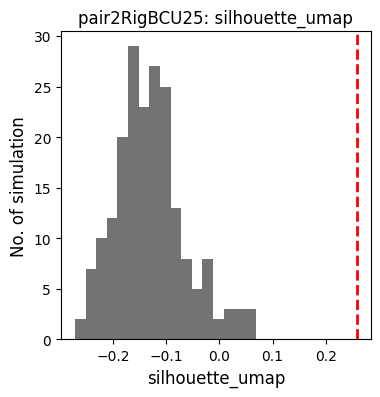

In [35]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

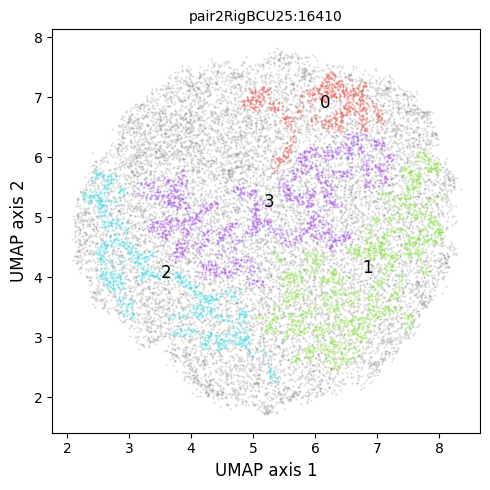

In [36]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [37]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [38]:
print(fn_csv)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/UMAPonVAE6/v/spec_goffinet_cutoff_256_176/pair2RigBCU25.random.embedding.csv


In [39]:
embed_r.shape

(16410, 43)

In [40]:
num_c

4